In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import calendar
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder,StandardScaler,Binarizer,PowerTransformer,FunctionTransformer,KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline




from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,learning_curve, cross_val_score,train_test_split
from sklearn.feature_selection import SelectKBest,f_classif, f_regression,chi2
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier



from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

## Summary of Data Science Process & Findings 

- Goal: Predict wine quality through other variables(acidity, sugar level, chlorides, sulfur dioxide, density, pH, sulphates, and alcohol)
- EDA
    - created feature engineered values diff acidity(fixed acidity - volatile acidity) and diff dioxide(total sulfur dioxide - free sulfur dioxide), as those values have similarity in measurements. Quantifying the differences might be contributive toward further predictions of wine quality
    - data is already cleaned, no null and extreme/unpractical outliers
    - wine quality is most correlated with volatile acidity and alcohol by heatmap and correlation
        -  "diff dioxide", "total sulfur dioxide", "free sulfur dioxide", "alcohol", and "diff acidity" are selected using SelectkBest
- predictions
    - feature engineer data
        - utilize binarizers(thresholding) and kBinsDiscretizer
        - utilize pipeline to automate and deal with feature engineering coherently
    - RandomForestClassifiers using GridSearchCV and randomSearchCV
        -plot training accuracy and testing accuracy with respect to random_states, max_depth, test_size, and etc
    
    - Support Vector Machines
        - Experiment SVC with linear, rbf, polynomial kernel
            -linear and polynomial kernel doesn't converge, therefore RBF is used
        - Tune Parameters (C, gamma, degree)
            - larger C avoids misclassification and potentially overfits
    - Guassian Naive Bayes
        -Doesn't perform as well as other models mentioned above
    - Stochastic Gradient Descent 
        -Doesn't perform well since increment in number of iterations doesn't improve its accuracy
            
- Conclusion
    - This project is a practice and demo of data science cycle, including Exploratory Data Analysis, Data Engineering, and Data Modelling (machine learning prediction). Due to limitations in domain knowledge, data engineering is restricted and doesn't raise the accuracy by a large amount. Within machine learning prediction, the goal was to predict the level of wine quality, and most of the predictions were accurate. RandomForestClassifier yields the best prediction accuracy, yet the training data sometimes overfit(training accuracy = 1). On the other hand, support vector machine has an accuracy around 85%, yet the training accuracy doesn't excel too much. Gaussian Naive Bayes and Stochastic Gradient Descent Classifier doesn't work well on the data, due to assumptions made on the models and can be inferred by the plots being drawn. Further research is required to make better engineered feature and optimize model through parameter tuning.<br> **Below are detailed descriptions,code, and plots of my work**

## EDA

In [58]:
wine=pd.read_csv("winequality-red.csv")
#feature engineered columns
wine["diff acidity"]=wine["fixed acidity"]-wine["volatile acidity"]
wine["diff dioxide"]=wine["total sulfur dioxide"]-wine["free sulfur dioxide"]

In [3]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
 12  diff acidity          1599 non-null   float64
 13  diff dioxide          1599 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 175.0 KB


In [59]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,diff acidity,diff dioxide
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023,7.791817,30.592871
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569,1.795322,27.056279
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,3.960000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000,6.540000,12.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000,7.330000,21.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000,8.770000,39.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,15.540000,251.500000


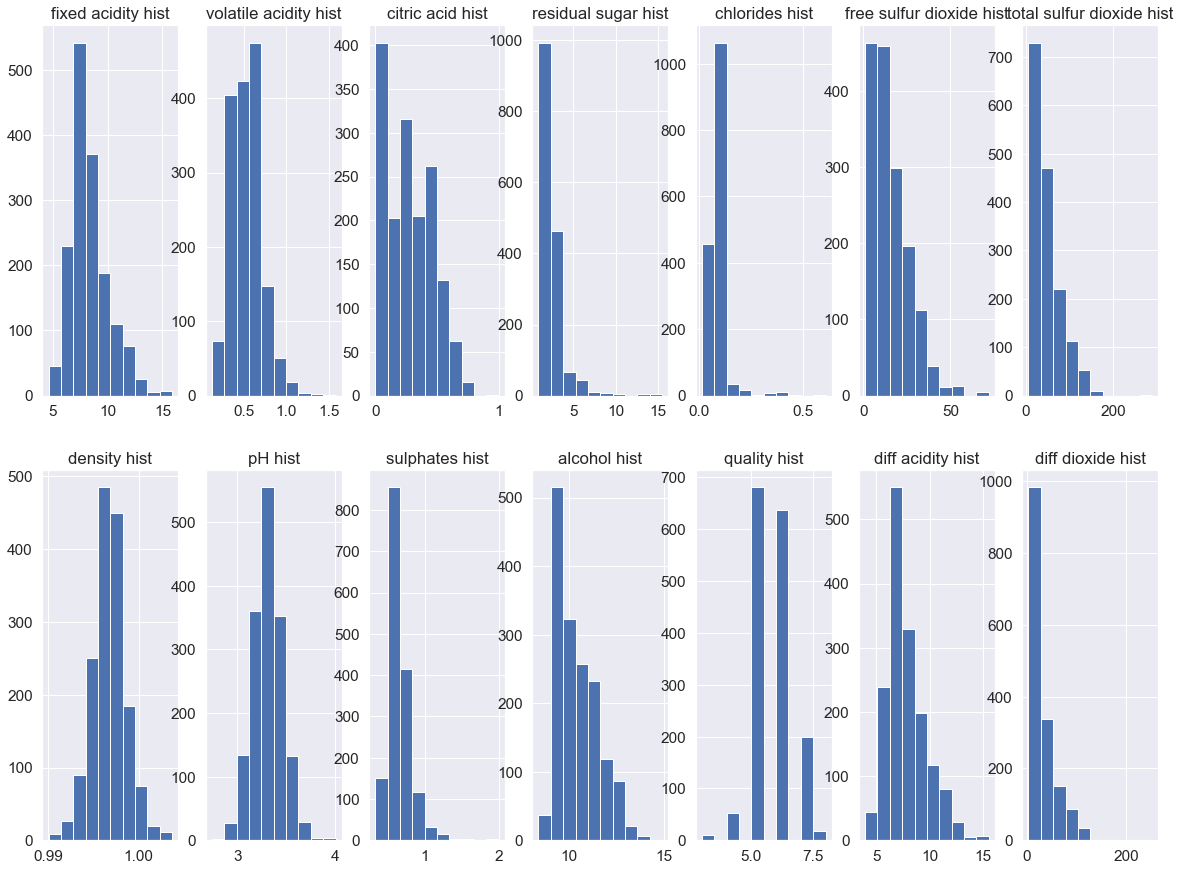

In [134]:
fig, axs = plt.subplots(2, 7,figsize=(20,15))

for i in range(14):
    axs[i//7, i%7].hist(wine[wine.columns[i]])
    axs[i//7, i%7].set_title(wine.columns[i]+' hist')

When histograms for each column are drawn, most histograms are normally distributed or slightly skewed. There aren't extreme outliers, indicating that values are reasonable. Below are other findings
- the histogram of "fixed acidity" and "volatile acidity" histogram have similar shapes, possibly suggesting certain correlations ("diff acidity" histogram also looks a bit similar to the two histograms)
- the histogram of "free sulfur dioxide" and "total sulfur dioxide" histogram have similar shapes, possibly suggesting correlations, so is "diff dioxide" histogram
- "residual sugar" and "chlorides" histogram have longer tails(more skewed). The outliers are noteworthy and possibly essential to prediction
- "density" and "pH" histograms are approximately normal and symmetric
- "quality" histogram has few data, some inadequate, on the two sides(worst quality and excellent quality), which might explain inaccurate predictions on quality through other variables. 


,correlation with quality
quality,1.000000
alcohol,0.476166
volatile acidity,0.390558
sulphates,0.251397
citric acid,0.226373
diff dioxide,0.205463
total sulfur dioxide,0.185100
density,0.174919
diff acidity,0.159258
chlorides,0.128907


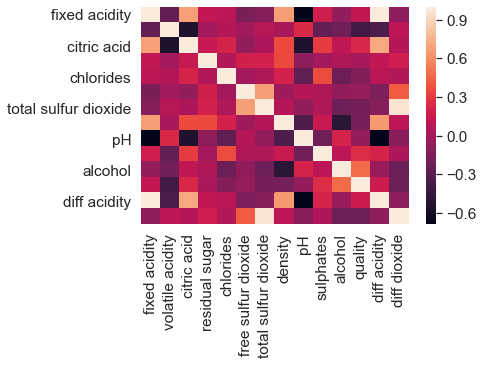

In [90]:
sns.heatmap(wine.corr())
quality_corr = pd.DataFrame(wine.corr()["quality"].abs().sort_values(ascending=False))
quality_corr.columns=pd.Series("correlation with quality")
quality_corr

Above is the correlation heat map between variables, with lighter orange and darker purple colors signifying stronger correlations. The goal is to predict wine quality using other variables, so we'll be primarily comparing wine quality with other variables with respect to the strength of correlation. Wine quality is then stronger correlated with volatile acidity and alcohol. Below are other interesting findings:
- fixed acidity is stronger correlated with volatile acidity, pH, and diff_acidity(since it's featured engineered using this variable). Additionally, volatile acidity is correlated with citric acid. 
- free sulfur dioxide is correlated with total sulfur dioxide. 
- density is stronger correlated with diff acidity, alcohol, pH, and fixed acidity, possibly due to the effects of alcohol and acids on its molecular structure
- pH is stronger correlated with acidity, which is reasonable because (stronger acidity indicates lower pH)
- Residual sugar and chlorides don't really correlate with other variables

In [112]:
selectkbest = SelectKBest(chi2, k=10)
selectkbest.fit_transform(wine.drop(columns="quality",axis=1), wine.quality)
wine.columns.drop("quality")[selectkbest.get_support()]

dfscores = pd.DataFrame(selectkbest.scores_)
dfcolumns = pd.DataFrame(wine.columns.drop("quality"))

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Variables','Score']
featureScores.nlargest(10,'Score')


,Variables,Score
12,diff dioxide,3226.439938
6,total sulfur dioxide,2755.557984
5,free sulfur dioxide,161.936036
10,alcohol,46.429892
11,diff acidity,19.328506
1,volatile acidity,15.580289
2,citric acid,13.025665
0,fixed acidity,11.260652
9,sulphates,4.558488
3,residual sugar,4.123295


SelectkBest yields different results to factors affecting wine quality. As larger score indicates larger influence on quality, "diff dioxide", "total sulfur dioxide", "free sulfur dioxide", "alcohol", and "diff acidity" are selected. 

In [104]:
wine.groupby("quality").mean()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,diff acidity,diff dioxide
quality,,,,,,,,,,,,,
3,8.360000,0.884500,0.171000,2.635000,0.122500,11.000000,24.900000,0.997464,3.398000,0.570000,9.955000,7.475500,13.900000
4,7.779245,0.693962,0.174151,2.694340,0.090679,12.264151,36.245283,0.996542,3.381509,0.596415,10.265094,7.085283,23.981132
5,8.167254,0.577041,0.243686,2.528855,0.092736,16.983847,56.513950,0.997104,3.304949,0.620969,9.899706,7.590213,39.530103
6,8.347179,0.497484,0.273824,2.477194,0.084956,15.711599,40.869906,0.996615,3.318072,0.675329,10.629519,7.849694,25.158307
7,8.872362,0.403920,0.375176,2.720603,0.076588,14.045226,35.020101,0.996104,3.290754,0.741256,11.465913,8.468442,20.974874
8,8.566667,0.423333,0.391111,2.577778,0.068444,13.277778,33.444444,0.995212,3.267222,0.767778,12.094444,8.143333,20.166667


Above is the value of variables grouped by quality. Some traits that might be contributive toward quality prediction:
- Volatile acidity,chlorides,and pH seems to decrease as quality increases
- Citric acid, sulphates, and alcohol increases as quality increases
- Amount of sulfur dioxide doesn't correlate well with the increase of quality(peaks at quality = 5)
- Diff acidity and diff dioxide doesn't correlate well with quality(Deviations occur at upper and lower qualities for diff dioxide)
- Density is uniform regardless of quality. 

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
3,10.0,9.955000,0.818009,8.4,9.725,9.925,10.575,11.0
4,53.0,10.265094,0.934776,9.0,9.600,10.000,11.000,13.1
5,681.0,9.899706,0.736521,8.5,9.400,9.700,10.200,14.9
6,638.0,10.629519,1.049639,8.4,9.800,10.500,11.300,14.0
7,199.0,11.465913,0.961933,9.2,10.800,11.500,12.100,14.0
8,18.0,12.094444,1.224011,9.8,11.325,12.150,12.875,14.0


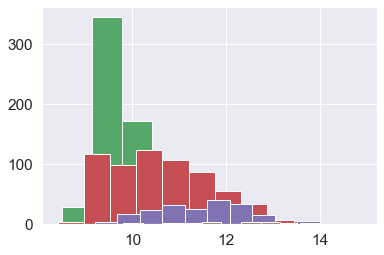

In [163]:
#fixed acidity
col_name="alcohol"
wine_df.groupby("quality")["alcohol"].hist()
wine_df.groupby("quality")["alcohol"].describe()


If we graph a histogram of alcohol amount grouped by quality, we can see a right shift in distribution as quality increases, which validates the above observation "alcohol quantity increases as wine quality increases

<AxesSubplot:xlabel='quality', ylabel='pH'>

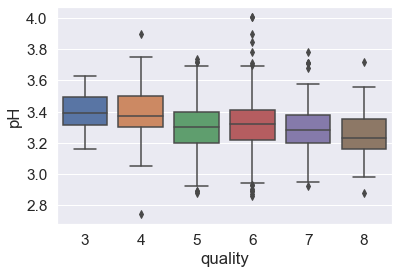

In [214]:
sns.boxplot(wine.quality, wine.pH)


<AxesSubplot:xlabel='quality', ylabel='alcohol'>

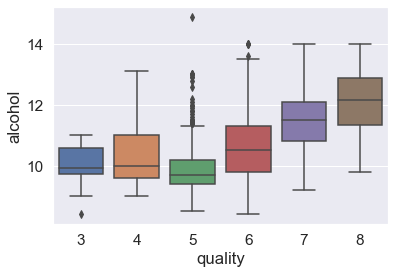

In [215]:
sns.boxplot(wine.quality, wine.alcohol)

In [209]:
#Observed tvd for volatile acidity(abs distance of variables from the mean)
0.5*np.sum(abs(wine.groupby("quality")["volatile acidity"].mean()-wine["volatile acidity"].mean()))

0.4153830614073616

In [124]:
#Do permutation tests to see the association between features and quality(check if the difference is caused by coincidence)
def permutation_tests(col_name):
    temp=wine.copy()
    tvd_list=[]
    obs=0.5*np.sum(abs(wine.groupby("quality")[col_name].mean()-wine[col_name].mean()))
    for _ in range(500):
        np.random.shuffle(temp[col_name])
        tvd=0.5*np.sum(abs(temp.groupby("quality")[col_name].mean()-temp[col_name].mean()))
        tvd_list.append(tvd)
    #print(tvd_list)
    #print(obs)
    return (np.array(tvd_list)>obs).mean()

col_probs=[]
for col_name in wine.columns[wine.columns!="quality"]:
    prob=permutation_tests(col_name)
    col_probs.append((col_name, prob))
col_probs


<ipython-input-124-e15d254e1e79>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  np.random.shuffle(temp[col_name])


[('fixed acidity', 0.154),
 ('volatile acidity', 0.0),
 ('citric acid', 0.0),
 ('residual sugar', 0.856),
 ('chlorides', 0.008),
 ('free sulfur dioxide', 0.004),
 ('total sulfur dioxide', 0.0),
 ('density', 0.0),
 ('pH', 0.006),
 ('sulphates', 0.0),
 ('alcohol', 0.0),
 ('diff acidity', 0.02),
 ('diff dioxide', 0.0)]

- Permutation test is done on each column with respect to quality to evaluate if the data/phenomenon of each variable can be explained by coincidence or is it associated with wine quality. Targeted column values is shuffled every trial. Data is then grouped by quality, and TVD(total variation distance) is computed. The trial TVD's are then compared with the observed TVD, which generates p-value and decides if null hypothesis(data is generated and explained by coincidence) is rejected. 
- As seen in the above data, every column except fixed acidity,diff acidity, and residual sugar is rejected on the level of 0.01. This doesn't ensure that other variables are accurate predictors of wine quality. Rather, it suggests that fixed acidity and residual sugar doesn't have large impact on wine quality.  
- Permutation tests is only a part of statistical analysis. It's not an effective indicator of evaluating dependency on wine quality. Other statistical methods will be used during machine learning predictions. 


In [ ]:
def convert_level(x):
    if(x in [3,4]):
        return 1
    elif(x in [5,6]):
        return 2
    return 3
#create another dataframe that converts wine quality to levels ([3,4] = 1, [5,6]=2, [7,8]=3)
wine_df=wine.copy()
wine_df["level"]=wine_df['quality'].apply(convert_level)

For classification purposes, we'll be categorizing quality into 3 categories, converting wine quality to levels ([3,4] = 1, [5,6]=2, [7,8]=3). We'll be performing Multi-class classification with different modellings. 

### RandomForestClassifier

[0.6958333333333333, 0.690625, 0.6875, 0.70625, 0.6799242424242424, 0.6857142857142857]


<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

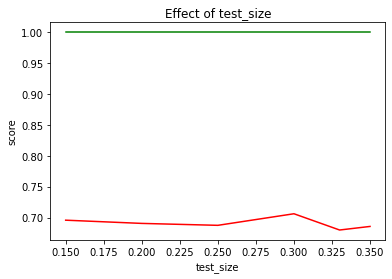

In [25]:
ts_scores=[]
tr_scores=[]
sizes=[0.15,0.2, 0.25, 0.3, 0.33,0.35]
for n in sizes:
    X_tr, X_ts, y_tr, y_ts = train_test_split(wine.drop(columns=["quality"]), wine["quality"] , test_size=n)

    rc=RandomForestClassifier()
    rc.fit(X_tr, y_tr)
    tr_scores.append(rc.score(X_tr, y_tr))
    ts_scores.append(rc.score(X_ts, y_ts))

print(ts_scores)
plt.title("Effect of test_size")
plt.xlabel("test_size")
plt.ylabel("score")
plt.plot(sizes, ts_scores,'r')
plt.plot(sizes, tr_scores,'g')
plt

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol',
       'quality', 'diff acidity'],
      dtype='object')
0.709375
[0.525, 0.525, 0.625, 0.69375, 0.640625, 0.671875, 0.703125, 0.684375, 0.709375]


<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

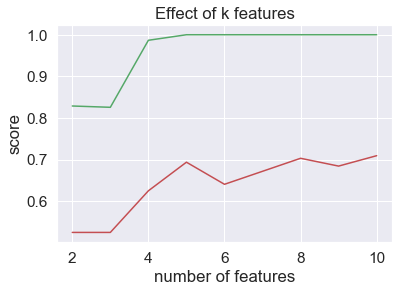

In [130]:
ts_scores = []
tr_scores = []
features = []
#iterate through k=2 to k=10
for i in np.arange(2,11):
    selectkbest = SelectKBest(chi2, k=i)
    #get k significant features and select those columns
    X_new = selectkbest.fit_transform(wine.drop(columns="quality",axis=1), wine.quality)
    features.append(selectkbest.get_support())
    X_tr, X_ts, y_tr, y_ts = train_test_split(X_new, wine["quality"] , test_size=0.2)
    rc=RandomForestClassifier()
    rc.fit(X_tr, y_tr)
    #append the training and test scores with the new data X_new
    tr_scores.append(rc.score(X_tr, y_tr))
    ts_scores.append(rc.score(X_ts, y_ts))

#select best k value that gives best test score
maxscore = np.argmax(ts_scores)
index = np.where(features[maxscore])[0]
print(wine.columns.take(index))
print(ts_scores[maxscore])
print(ts_scores)

plt.title("Effect of k features")
plt.xlabel("number of features")
plt.ylabel("score")
plt.plot(np.arange(2,11), ts_scores,'r')
plt.plot(np.arange(2,11), tr_scores,'g')
plt



<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

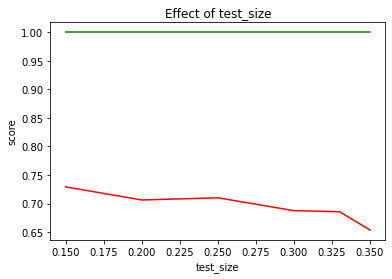

In [31]:

ts_scores=[]
tr_scores=[]
sizes=[0.15,0.2, 0.25, 0.3, 0.33,0.35]
for n in sizes:
    X_tr, X_ts, y_tr, y_ts = train_test_split(wine.drop(columns="quality"), wine["quality"] , test_size=n)


    svc=RandomForestClassifier()
    svc.fit(X_tr, y_tr)
    tr_scores.append(svc.score(X_tr, y_tr))
    ts_scores.append(svc.score(X_ts, y_ts))
    
plt.title("Effect of test_size")
plt.xlabel("test_size")
plt.ylabel("score")
plt.plot(sizes, ts_scores,'r')
plt.plot(sizes, tr_scores,'g')
plt

In [248]:
#Pipeline
def pipeline(n):
    preproc = ColumnTransformer(
        transformers=[
            ('regular', FunctionTransformer(lambda x: x), wine.drop(columns=["quality"]).columns),
            ('volatile_binarizer', Binarizer(threshold=0.93), ["volatile acidity"]),
            ('alcohol_binarizer', Binarizer(threshold=11), ["alcohol"]),
            ('chlorides_binarizer', Binarizer(threshold=0.35), ['chlorides']),
            #('fixed_binarizer', Binarizer(threshold=10), ["fixed acidity"]),
            ('pH_binarizer', Binarizer(threshold=3.8), ["pH"]),
            ('pH_kbins', KBinsDiscretizer(n_bins=3), ["pH"]),
            #('volatile_kbins',  KBinsDiscretizer(n_bins=2), ["volatile acidity"]),
            #('fixed_kbins',  KBinsDiscretizer(n_bins=8), ["fixed acidity"]),
            #('alcohol_kbins', KBinsDiscretizer(n_bins=8), ["alcohol"]),
        ])
    pl = Pipeline(steps=[('preprocessor', preproc),('classify', RandomForestClassifier(n_estimators=500,max_depth=n))])
    return pl



## GridSearchCV & RandomSearchCV

In [33]:
#GridSearchCV
parameters = {
    #'preprocessor__volatile_binarizer__threshold':np.arange(0.75, 1.2, 0.02),
    #'preprocessor__alcohol_binarizer__threshold':np.arange(10, 13, 0.2),
    #'preprocessor__chlorides_binarizer__threshold':np.arange(0.25, 0.61, 0.05),
    'preprocessor__pH_binarizer__threshold':np.arange(3, 4, 0.05),
    "preprocessor__pH_kbins__n_bins":np.arange(2, 9,1),
    #"preprocessor__volatile_kbins__n_bins":np.arange(2, 9,1),
    #"preprocessor__fixed_kbins__n_bins":np.arange(5, 9,1),
    #"preprocessor__alcohol_kbins__n_bins":np.arange(2, 9,1),
      
}
'''classify__max_depth': [None,2,3,4,5,7,10,13,15], 
'classify__min_samples_split':[None,2,3,5,7,10,15],
'classify__min_samples_leaf':[None,2,3,5,7,10,15,20]'''
clf=GridSearchCV(pl, parameters, cv = 10)
clf.fit(X_tr, y_tr)
clf.best_estimator_.score(X_ts, y_ts)



/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


0.685

In [232]:
sc=[]
for i in range(20):
    X_tr, X_ts, y_tr, y_ts = train_test_split(wine_df.drop(columns=["quality","level"]), wine_df.level, test_size=0.25)
    #X_tr, X_ts, y_tr, y_ts = train_test_split(wine.drop(columns=["quality"]), wine.quality, test_size=0.25)
    clf.best_estimator_.fit(X_tr, y_tr)
    sc.append(clf.best_estimator_.score(X_ts, y_ts))
print(sum(sc)/len(sc))

0.8700000000000001


In [35]:
clf.best_estimator_

#RandomForestClassifier?

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('regular',
                                                  FunctionTransformer(func=<function pipeline.<locals>.<lambda> at 0x7fabcc931ee0>),
                                                  Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'diff acidity', 'diff dioxide'],
      dtype='object')),
                                                 ('volatile_binarizer',
                                                  Binarizer(threshold=0.93),
                                                  ['volatile acidity']),
                                                 ('chlorides_binarizer',
                                                  Binarizer(threshold=0.35),
                                                  ['chlorides']),
                                    

<AxesSubplot:>

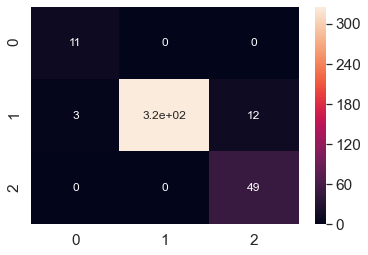

In [278]:
X_tr, X_ts, y_tr, y_ts = train_test_split(wine_df.drop(columns=["quality","level"]), wine_df.level, test_size=0.25)
#clf.best_estimator_.fit(X_tr, y_tr)
matrix=confusion_matrix(clf.predict(X_ts),y_ts)
df_cm = pd.DataFrame(matrix)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12})

- When evaluating the efficiency of this model, we can utilize recall as examination measure. We would certainly want people to drink labelled-level 3 wine to enjoy actual level-3 quality/taste. In this sense, recall, the proportion of predicted-level3 wine being actually level3 quality, is a more suitable measure. Recall = 49/(49+12)=0.889=80.3%. 
- For wine companies, besides guaranteeing wine quality, they would also want to ensure that all level3 quality wine are being labelled as level3, so that they can maximize their profit and prevent loss. In this sense, precision, the proportion of actual level 3 wine being labelled as level3, is a more suitable measure. Precision = 49/49=100%, a really ideal result. 

[0.83325 0.84175 0.8505  0.86125 0.8645  0.8615  0.871   0.8695  0.868
 0.877   0.8745  0.86975]
[0.82210175 0.86363636 0.90383653 0.94361968 0.97197665 0.98807339
 0.99658048 0.99899917 1.         1.         1.         1.        ]
0.861875
0.9574020016680568


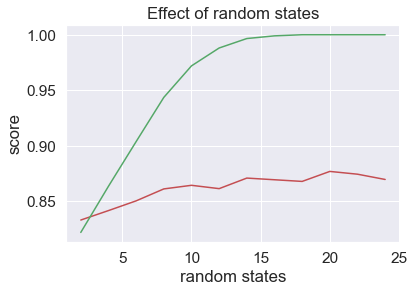

In [249]:
#Experiment on accuracy with respect to max_depth
test_scores=[]
train_scores=[]

var_size=np.arange(2, 25, 2)
for n in var_size:
    pl=pipeline(n)
    temp_ts=[]
    temp_tr=[]
    for i in range(10):
        #X_tr, X_ts, y_tr, y_ts = train_test_split(wine.drop(columns=["quality"]), wine.quality, test_size=0.25)
        X_tr, X_ts, y_tr, y_ts = train_test_split(wine_df.drop(columns=["quality","level"]), wine_df.level, test_size=0.25)
        pl.fit(X_tr, y_tr)
        temp_ts.append(pl.score(X_ts, y_ts))
        temp_tr.append(pl.score(X_tr, y_tr))
        
    test_scores.append(sum(temp_ts)/len(temp_ts))
    train_scores.append(sum(temp_tr)/len(temp_tr))

plt.title("Effect of random states")
plt.xlabel("random states")
plt.ylabel("score")
plt.plot(var_size, test_scores,'r')
plt.plot(var_size, train_scores,'g')
plt

test_scores=np.array(test_scores)
train_scores=np.array(train_scores)

print(test_scores)
print(train_scores)
print(test_scores.mean())
print(train_scores.mean())



- GridSearchCV is utilized tune parameters within the feature-engineered variables(binarizers and bin-discretizers). I decided to tune pH_binarizer threshold and number of bins for pH as well as those for volatile acidity and alcohol. For demo purposes, only kbinsDiscretizers are implemented on pH variable, as GridSearchCV requires a lot of time on complex experimentation. For the volatile acidity, chlorides, and alcohol, the values for binarizers are set arbitrarily using previous GridSearch result for each variable. 
- GridSearchCV utilizes cross-validation and picks the optimal model. The best estimator then gives a 0.87 average accuracy on the test set, which is ideal, although more adjustments can be made to increase the testing accuracy above 0.9.
- The last plot shows how the number of max_depth affect training and testing accuracy. The training accuracy eventually reaches an asymptote, which makes the increment of random_states unneccesary. I decided to not add max_depth, random_states, min/max-sample leaf into the GridSearchCV parameters because those variables don't have large effect on the testing accuracy, and increasing the values to the variables would lead to overfit.

In [247]:
'''
#TODO: Replace GridSearchCV with RandomizedSearchCV
#Reason: explore 1,000 different values for each hyperparameter (instead of just a few values per hyperparameter with the gridSearch).
'''
rand_params= {
    'preprocessor__volatile_binarizer__threshold':np.arange(0.75, 1.2, 0.02),
    'preprocessor__alcohol_binarizer__threshold':np.arange(10, 13, 0.2),
    'preprocessor__chlorides_binarizer__threshold':np.arange(0.25, 0.61, 0.01),
    'preprocessor__pH_binarizer__threshold':np.arange(3, 4, 0.05),
    "preprocessor__pH_kbins__n_bins":np.arange(2, 9,1),
    
    
    
    #"preprocessor__volatile_kbins__n_bins":np.arange(2, 9,1),
    #"preprocessor__fixed_kbins__n_bins":np.arange(5, 9,1),
    #"preprocessor__alcohol_kbins__n_bins":np.arange(2, 9,1),
    
    
    
}
clf_random=RandomizedSearchCV(pl, rand_params, cv = 5, n_iter=1000)
clf_random.fit(X_tr, y_tr)
clf_random.best_estimator_.score(X_ts, y_ts)

0.875

In [272]:
clf_random.best_estimator_


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('regular',
                                                  FunctionTransformer(func=<function pipeline.<locals>.<lambda> at 0x7fabb5f888b0>),
                                                  Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'diff acidity', 'diff dioxide'],
      dtype='o...
                                                  Binarizer(threshold=0.77),
                                                  ['volatile acidity']),
                                                 ('alcohol_binarizer',
                                                  Binarizer(threshold=10.0),
                                                  ['alcohol']),
                                                 ('chlorides_binarizer',
                                             

<AxesSubplot:>

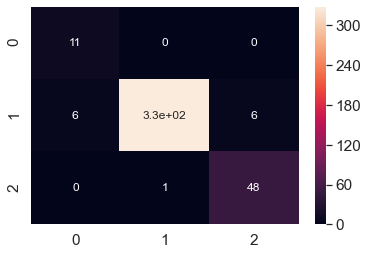

In [277]:
#X_tr, X_ts, y_tr, y_ts = train_test_split(wine.drop(columns=["quality"]), wine.quality, test_size=0.25)
X_tr, X_ts, y_tr, y_ts = train_test_split(wine_df.drop(columns=["quality","level"]), wine_df.level, test_size=0.25)
#clf.best_estimator_.fit(X_tr, y_tr)
matrix=confusion_matrix(clf.predict(X_ts),y_ts)
df_cm = pd.DataFrame(matrix)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12})



- When drawing the confusion matrix, most data are classified correctly, especially those with level 1 and 3 (wine quality = [3,4] and [7,8]). Some data in level 2(label = 1) are misclassified incorrectly. Potential reasons might be the existence of marginal differences between some level 2 and 3 wine traits(8 of them being misclassified as level 3). It's easier for actual level 1 (label = 0) and level 3(label=2) wine to be correctly classified because of their distinct traits. Yet, some level 2 wine have shown similarities with level 3 wine. More EDA is required to eliminate those misclassified data. 
- When evaluating the efficiency of this model, we can utilize recall as examination measure. We would certainly want people to drink labelled-level 3 wine to enjoy actual level-3 quality/taste. In this sense, recall, the proportion of predicted-level3 wine being actually level3 quality, is a more suitable measure. Recall = 48/(48+6)=0.889=88.9%. 
- For wine companies, besides guaranteeing wine quality, they would also want to ensure that all level3 quality wine are being labelled as level3, so that they can maximize their profit and prevent loss. In this sense, precision, the proportion of actual level 3 wine being labelled as level3, is a more suitable measure. Precision = 48/(48+1)=98%, slightly lower than that using GridSearchCV. 
- Although the precision decreases by 2%,the recall has increased by 8.6%, which is indeed an improvement in modelling and suggesting that RandomSearchCV, in this case, has given a better model than GridSearchCV. This tradeoff is worthy because, given actual level3 wine labelled 2% incorrectly, customers are 8.6% more likely to actually enjoy actual level3 wine that they expected(on the label) - significiant in maintaining the wine brand's reputation and expectations.

## LinearSVC

### Dataframe engineered (without pipeline)

In [291]:
eng_df=wine_df.copy()
bin_cols=["volatile acidity", "chlorides", "pH", "fixed acidity","alcohol"]
bin_thres=[0.93,0.35, 3.8, 10, 11]
for i in range(len(bin_cols)):
    eng_df=pd.concat([eng_df, pd.Series(name=bin_cols[i][:3]+"_binarize", data=Binarizer(threshold=bin_thres[i]).fit_transform(wine_df[[bin_cols[i]]]).flatten())],axis=1)
eng_scaled=pd.DataFrame(scaler.fit_transform(eng_df.drop(columns="quality")), columns=eng_df.columns[~(eng_df.columns=="quality")])
eng_scaled


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,diff acidity,diff dioxide,level,vol_binarize,chl_binarize,pH_binarize,fix_binarize,alc_binarize
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,-0.608336,-0.280720,-0.236503,-0.156024,-0.106701,-0.056007,-0.433549,-0.585294
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,-0.485757,0.421739,-0.236503,-0.156024,-0.106701,-0.056007,-0.433549,-0.585294
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,-0.418895,0.310825,-0.236503,-0.156024,-0.106701,-0.056007,-0.433549,-0.585294
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,1.742953,0.458711,-0.236503,-0.156024,-0.106701,-0.056007,2.306547,-0.585294
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,-0.608336,-0.280720,-0.236503,-0.156024,-0.106701,-0.056007,-0.433549,-0.585294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217796,0.403229,-0.980669,-0.382271,0.053845,1.542054,-0.075043,-0.978765,0.899886,-0.461180,0.072294,-1.221231,-0.687407,-0.236503,-0.156024,-0.106701,-0.056007,-0.433549,-0.585294
1595,-1.390155,0.123905,-0.877968,-0.240375,-0.541259,2.211469,0.137820,-0.862162,1.353436,0.601055,0.729364,-1.360525,-0.687407,-0.236503,-0.156024,-0.106701,-0.056007,-0.433549,1.708543
1596,-1.160343,-0.099554,-0.723916,-0.169427,-0.243707,1.255161,-0.196679,-0.533554,0.705508,0.542042,0.541630,-1.115367,-0.724379,-0.236503,-0.156024,-0.106701,-0.056007,-0.433549,-0.585294
1597,-1.390155,0.654620,-0.775267,-0.382271,-0.264960,1.542054,-0.075043,-0.676657,1.677400,0.305990,-0.209308,-1.413457,-0.687407,-0.236503,-0.156024,-0.106701,-0.056007,-0.433549,-0.585294


Due to lack of domain knowledge in chemistry, I will be using binarizers and thresholding to perform feature engineer, assuming that exceeding certain chemical values will effectively distinguish good quality and bad quality wine. Variables "volatile acidity", "chlorides", "pH", "fixed acidity","alcohol" are picked, as acidity, pH, and alcohol should be good indicators of wine quality. Thresholds picked are assigned arbitrary using optimal values  through GridSearchCV. After binarized data are appended, it is normalized and adjusted to unit variance, to allow better performance in some models. 

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

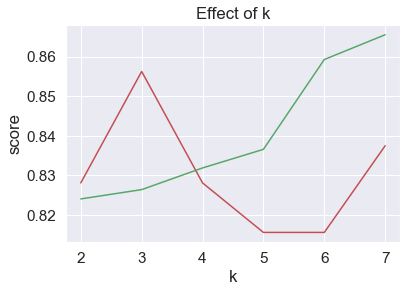

In [292]:
scaler = StandardScaler()
#df_scaled = pd.DataFrame(scaler.fit_transform(wine.drop(columns=["quality", "diff acidity"])), columns=wine.columns[~(wine.columns=="quality") & ~(wine.columns=="diff acidity")])


df_scaled = eng_scaled.copy()
#df_scaled = pd.DataFrame(scaler.fit_transform(wine.drop(columns="quality")), columns=wine.columns[~(wine.columns=="quality")])
ts_scores=[]
tr_scores=[]
sizes=[0.15,0.2, 0.25, 0.3, 0.33,0.35,0.4]
k_arr=np.arange(2,8)
for n in k_arr:
    
    selectkbest = SelectKBest(f_classif, k=n)
    X_new = selectkbest.fit_transform(df_scaled, wine_df.level)
    X_tr, X_ts, y_tr, y_ts = train_test_split(X_new, wine_df["level"] , test_size=0.2)
    svc=svm.SVC(kernel="rbf", C=3)
    svc.fit(X_tr, y_tr)
    tr_scores.append(svc.score(X_tr, y_tr))
    ts_scores.append(svc.score(X_ts, y_ts))
    
plt.title("Effect of k")
plt.xlabel("k")
plt.ylabel("score")
plt.plot(k_arr, ts_scores,'r')
plt.plot(k_arr, tr_scores,'g')
plt
#wine.quality.value_counts()


The first plot focuses on feature selection using selectKBest, then training those selected data with Support Vector machine. LinearSVC isn't used because the cost doesn't converge and it is applicable when data are linearly separable. Therefore, we used radial-based kernel instead. The testing accuracy is around 0.85 with best k value. Parameter C can be tuned to acquire balance between correct classification and maximizing decision boundary(away from other data ponts). 

In [315]:
#df_scaled = pd.DataFrame(scaler.fit_transform(wine.drop(columns="quality")), columns=wine.columns[~(wine.columns=="quality")])
eng_scaled = pd.DataFrame(scaler.fit_transform(eng_df.drop(columns=["quality","level"])), columns=eng_df.columns[(eng_df.columns!="quality") & (eng_df.columns!="level")])





test_scores=[]
train_scores=[]
for i in range(10):
    X_tr, X_ts, y_tr, y_ts = train_test_split(eng_scaled, wine_df["level"] , test_size=0.25)
    #svc=LinearSVC()
    #adjust C & gamma
    svc=svm.SVC(kernel='rbf', C=3)
    #adjust kernel=poly and degree
    #svc=svm.SVC(kernel="poly", degree=3, C=10)
    svc.fit(X_tr, y_tr)
    train_scores.append(svc.score(X_tr, y_tr))
    test_scores.append(svc.score(X_ts, y_ts))
train_scores=np.array(train_scores)
test_scores=np.array(test_scores)
print(train_scores.mean())
print(test_scores)

'''test_scores=[]
train_scores=[]
for i in range(10):
    X_tr, X_ts, y_tr, y_ts = train_test_split(df_scaled, wine["quality"] , test_size=0.25)
    svc=LinearSVC(max_iter=10000)
    svc.fit(X_tr, y_tr)
    train_scores.append(svc.score(X_tr, y_tr))
    test_scores.append(svc.score(X_ts, y_ts))
train_scores=np.array(train_scores)
test_scores=np.array(test_scores)
print(train_scores.mean())
print(test_scores.mean())'''

    

0.8814845704753962
[0.8425 0.8375 0.8375 0.8625 0.8275 0.83   0.87   0.8525 0.84   0.8375]


'test_scores=[]\ntrain_scores=[]\nfor i in range(10):\n    X_tr, X_ts, y_tr, y_ts = train_test_split(df_scaled, wine["quality"] , test_size=0.25)\n    svc=LinearSVC(max_iter=10000)\n    svc.fit(X_tr, y_tr)\n    train_scores.append(svc.score(X_tr, y_tr))\n    test_scores.append(svc.score(X_ts, y_ts))\ntrain_scores=np.array(train_scores)\ntest_scores=np.array(test_scores)\nprint(train_scores.mean())\nprint(test_scores.mean())'

The second analysis was done without feature selection, directly training on SVC.The result was approximately the same. Something to note is that SVC doesn't overfit the training data given our C value, as the training accuracy is only slightly higher than the testing accuracy.

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

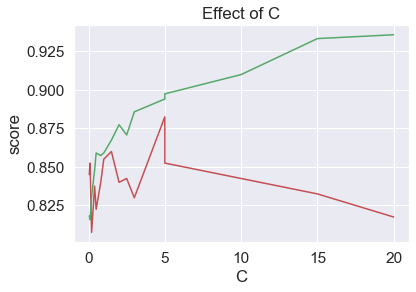

In [319]:
test_scores=[]
train_scores=[]
C_nums=[0.05, 0.1, 0.2, 0.4, 0.5, 0.8, 1, 1.5, 2, 2.5, 3,5, 5, 10,15,20]
for i in C_nums:
    X_tr, X_ts, y_tr, y_ts = train_test_split(eng_scaled, wine_df["level"] , test_size=0.25)
    #svc=LinearSVC()
    #adjust C & gamma
    svc=svm.SVC(kernel='rbf', C=i)
    #adjust kernel=poly and degree
    #svc=svm.SVC(kernel="poly", degree=3, C=10)
    svc.fit(X_tr, y_tr)
    train_scores.append(svc.score(X_tr, y_tr))
    test_scores.append(svc.score(X_ts, y_ts))
train_scores=np.array(train_scores)
test_scores=np.array(test_scores)
plt.title("Effect of C")
plt.xlabel("C")
plt.ylabel("score")
plt.plot(C_nums, test_scores,'r')
plt.plot(C_nums, train_scores,'g')
plt


Larger C creates smaller margin for decision boundaries, while smaller C values maximizes larger margin/distance between decision boundaries and trading off with accuracy. As C becomes too large, overfitting will occur, so training accuracy increase, yet testing accuracy will remain approximately the same value or decrease. 

### Logistic Regression

In [ ]:
#logistic regression is used for two-class classification, therefore classification is grouped by l
ts_scores=[]
tr_scores=[]
sizes=[0.15,0.2, 0.25, 0.3, 0.33,0.35]
for n in sizes:
    X_tr, X_ts, y_tr, y_ts = train_test_split(wine_df.drop(columns=["quality","level"]), wine_df["level"] , test_size=n)
    #X_tr, X_ts, y_tr, y_ts = train_test_split(wine.drop(columns=["quality"]), wine_df["quality"] , test_size=n)

    reg=LogisticRegression(max_iter=10000, multi_class='multinomial', solver='lbfgs')
    reg.fit(X_tr, y_tr)
    tr_scores.append(reg.score(X_tr, y_tr))
    ts_scores.append(reg.score(X_ts, y_ts))
    
print(ts_scores)
plt.title("Effect of test_size")
plt.xlabel("test_size")
plt.ylabel("score")
plt.plot(sizes, ts_scores,'r')
plt.plot(sizes, tr_scores,'g')
plt

Comparing to other models, Logistic Regression gives an acceptable result consistently larger than 0.815 regardless of test size. One of the differences/advantages of Logistic Regression is that it doesn't overfit on training data, as the accuracy flunctuates between [84%, 85%] (comparing to RandomForestClassifier which gives training data 100% accuracy). SVM works better than Logistic Regression because Logistic Regression is a lienar model, while SVM creates non-linear decision boundaries.

### Guassian Naive-Bayes

In [229]:
X_tr, X_ts, y_tr, y_ts = train_test_split(wine_df.drop(columns=["quality","level"]), wine_df.level, test_size=0.25)

gnb=GaussianNB()
gnb.fit(X_tr, y_tr)
print(gnb.score(X_tr, y_tr))
gnb.score(X_ts, y_ts)
#wine.columns


0.7656380316930775


0.7525

Guassian Naive-Bayes model doesn't yield the best result because it assumes variables are normally distributed. Yet, some of our variables(shown in above histogram in EDA) are skewed, which makes this modelling less suitable. It also assumes variables to be conditionally independent, which isn't necessarily true, as density, pH, and acidity are correlated have complex relationships.

### Sochastic Gradient Descent Classifier

In [234]:
sgd=SGDClassifier(max_iter=2000)
sgd.fit(X_tr, y_tr)
print(sgd.score(X_tr, y_tr))
sgd.score(X_ts, y_ts)

0.8273561301084237


0.8175

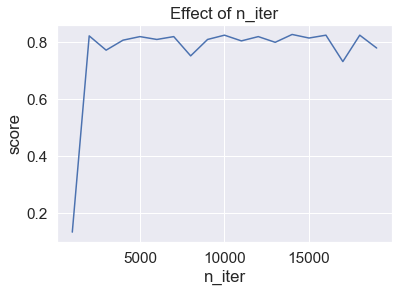

In [238]:
scores = []
for i in range(1000,20000,1000):
    sgd=SGDClassifier(max_iter=i)
    sgd.fit(X_tr, y_tr)
    scores.append(sgd.score(X_ts, y_ts))
plt.title("Effect of n_iter")
plt.xlabel("n_iter")
plt.ylabel("score")
plt.plot(np.arange(1000,20000,1000), scores) 
#scores

As seen above, sochastic gradient descent classifier doesn't work optimally regardless of the number of iterations. It reached an asymptotic accuracy of 0.8 at around 2500 iterations. Other parameters an be tuned to maximize performance. Yet, it also suggests a better feature engineering and selection is required to improve testing accuracy

# Conclusion
This project is a practice and demo of data science cycle, including Exploratory Data Analysis, Data Engineering, and Data Modelling (machine learning prediction). Due to limitations in domain knowledge, data engineering is restricted and doesn't raise the accuracy by a large amount. Within machine learning prediction, the goal was to predict the level of wine quality, and most of the predictions were accurate. RandomForestClassifier yields the best prediction accuracy, yet the training data sometimes overfit(training accuracy = 1). On the other hand, support vector machine has an accuracy around 85%, yet the training accuracy doesn't excel too much. Gaussian Naive Bayes and Stochastic Gradient Descent Classifier doesn't work well on the data, due to assumptions made on the models and can be inferred by the plots being drawn. Further research is required to make better engineered feature and optimize model through parameter tuning.

## Additional Experimentation

In [323]:
# Create additional features
def create_product_variables(df,x,y):
    df[str(df.columns[x])+"*"+str(df.columns[y])]=np.multiply(df.iloc[:,x],df.iloc[:,y])
    #return pd.Series(name=str(x)+"_"+str(y),data=np.multiply(wine[x],wine[y]))
n=len(wine.columns)
prod_df=wine.copy()
for i in range(n):
    for j in range(i, n):
        #wine=pd.concat([wine, create_product_variables(wine.columns[i],wine.columns[j])])
        if(prod_df.columns[i]=="quality"):
            break
        if(prod_df.columns[j]!="quality"):
            create_product_variables(prod_df,i,j)
def get_k_largest(df, k_num): 
    selectkbest = SelectKBest(chi2, k=k_num)
    selectkbest.fit_transform(df.drop(columns="quality",axis=1), df.quality)
    df.columns.drop("quality")[selectkbest.get_support()]

    dfscores = pd.DataFrame(selectkbest.scores_)
    dfcolumns = pd.DataFrame(df.columns.drop("quality"))

    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Variables','Score']
    return featureScores.nlargest(k_num,'Score')
#temp_var=get_k_largest(prod_df, 20)["Variables"].values
len(prod_df.columns)



105

index = 66
0.903125
[0.828125, 0.83125, 0.80625, 0.828125, 0.81875, 0.815625, 0.821875, 0.821875, 0.8375, 0.8375, 0.83125, 0.8, 0.840625, 0.85625, 0.859375, 0.853125, 0.865625, 0.89375, 0.84375, 0.8875, 0.853125, 0.875, 0.840625, 0.86875, 0.875, 0.871875, 0.85625, 0.884375, 0.85, 0.884375, 0.86875, 0.853125, 0.86875, 0.890625, 0.8875, 0.884375, 0.865625, 0.8375, 0.846875, 0.89375, 0.809375, 0.878125, 0.875, 0.853125, 0.88125, 0.871875, 0.859375, 0.871875, 0.86875, 0.859375, 0.871875, 0.85625, 0.86875, 0.865625, 0.88125, 0.85, 0.884375, 0.85, 0.89375, 0.85, 0.86875, 0.871875, 0.875, 0.88125, 0.875, 0.853125, 0.903125, 0.871875]


<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

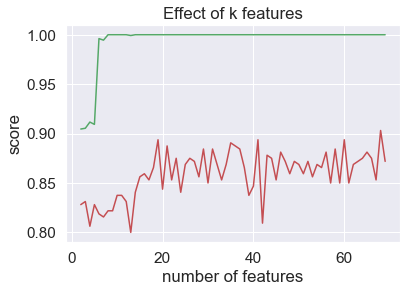

In [324]:
ts_scores = []
tr_scores = []
features = []
prod_df["level"]=prod_df['quality'].apply(convert_level)
#iterate through k=2 to k=10
for i in np.arange(2,70):
    selectkbest = SelectKBest(chi2, k=i)
    #get k significant features and select those columns
    X_new = selectkbest.fit_transform(prod_df.drop(columns=["quality","level"],axis=1), prod_df.level)
    features.append(selectkbest.get_support())
    X_tr, X_ts, y_tr, y_ts = train_test_split(X_new, prod_df["level"] , test_size=0.2)
    rc=RandomForestClassifier()
    rc.fit(X_tr, y_tr)
    #append the training and test scores with the new data X_new
    tr_scores.append(rc.score(X_tr, y_tr))
    ts_scores.append(rc.score(X_ts, y_ts))

#select best k value that gives best test score
maxscore = np.argmax(ts_scores)
index = np.where(features[maxscore])[0]
print("index = "+str(maxscore))
print(ts_scores[maxscore])
print(ts_scores)

plt.title("Effect of k features")
plt.xlabel("number of features")
plt.ylabel("score")
plt.plot(np.arange(2,70), ts_scores,'r')
plt.plot(np.arange(2,70), tr_scores,'g')
plt

For experimental purpose, I multiplied variables toward each other, as some variable products might have signficance and is directly associated with wine quality. A plot of testing accuracy vs number of features is plotted modelled through RandomForestClassifier, giving a better testing accuracy(>0.9) than original data. More exploration is required to prevent overfitting and maximizing accuracy.